# 0 环境配置

In [1]:

import numpy as np
import os
import sys, time
sys.path.append('../')

import matplotlib.pyplot as plt
%matplotlib inline

from model.loss import myloss
from model.metric import all_accuracy
from keras.applications.xception import preprocess_input
from keras.callbacks import Callback, EarlyStopping
from model.DepthwiseConv2D import DepthwiseConv2D
from model.switchnorm import SwitchNormalization
from keras.utils import multi_gpu_model
from keras.optimizers import *
from keras.models import load_model
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

from dataload.data_generator import *
from model.core_model import model_v1 as my_model

gpus = 2
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
config = tf.ConfigProto() 
config.gpu_options.per_process_gpu_memory_fraction = 0.95
session = tf.Session(config=config)


/home/ubuntu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1 预设参数

In [2]:
base_project = os.path.abspath('../')
data_dir    = os.path.join(base_project, 'dataspace')
model_name = 'model_v1'
image_size = (512, 512)
mask_size  = (31, 31, 31, 31)

# 2 数据生成

In [3]:
threshold = 0.0
heatmap_height = mask_size[0]
heatmap_width  = mask_size[1]

train_batch_size = 16
valid_batch_size = 16

train_gen = MyImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rotation_range=6,
    channel_shift_range=15,
    zoom_range=(.9, 1.1),
    horizontal_flip=True
)

gen = MyImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_gen.myflow_from_directory(os.path.join(data_dir, 'train'),
                                                  target_size       = image_size,
                                                  x_threshold       = threshold,
                                                  y_threshold       = threshold,
                                                  dataset_mode      = 'train',
                                                  heatmap_height    = heatmap_height,
                                                  heatmap_width     = heatmap_width,
                                                  batch_size        = train_batch_size)

valid_generator = gen.myflow_from_directory(os.path.join(data_dir, 'valid'), 
                                           target_size       = image_size,
                                           x_threshold       = threshold,
                                           y_threshold       = threshold,
                                           dataset_mode      = 'valid',
                                           heatmap_height    = heatmap_height,
                                           heatmap_width     = heatmap_width,
                                           batch_size        = valid_batch_size)
train_samples_epoch = train_generator.data_num
print("samples_train_epoch = {}".format(train_samples_epoch))

steps_train = len(train_generator)
print("steps_train = {}".format(steps_train))

valid_samples_epoch = valid_generator.data_num
print("samples_valid_epoch = {}".format(valid_samples_epoch))

steps_valid = len(valid_generator)
print("steps_valid = {}".format(steps_valid))


Found 414972 image pairs.
Found 87753 image pairs.
samples_train_epoch = 414972
steps_train = 12968
samples_valid_epoch = 87753
steps_valid = 2743


# 3 搭建模型

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
vision_model (Model)            (None, 31, 31, 768)  8975264     input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
similarity_reshape_b (Reshape)  (None, 961, 768)     0           vision_model[2][0]               
__________

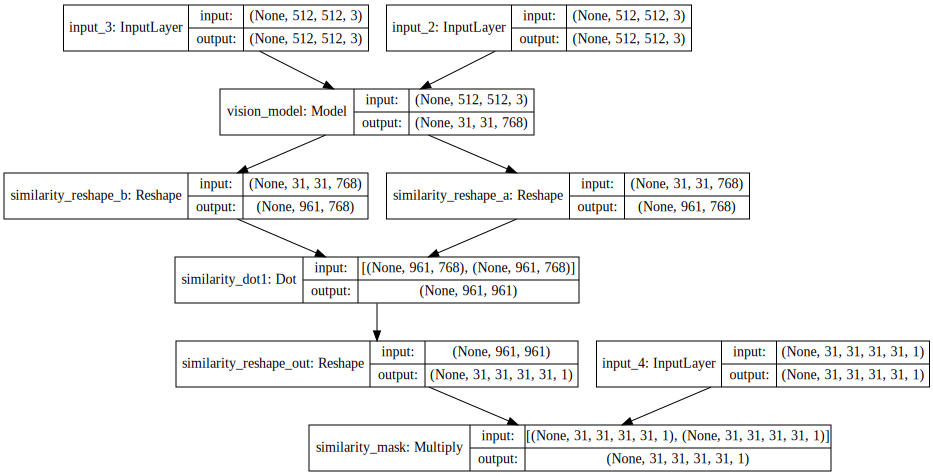

In [4]:
model = my_model(image_size=image_size, mask_size=mask_size)
model.summary()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# 4 训练模型

In [5]:
model_path = os.path.join(base_project,  'checkpoints/' + model_name)

if not os.path.exists(model_path):
    os.makedirs(model_path)

class MyModelCheckpoint(Callback):
    def __init__(self, model, path, init_loss=np.inf, init_acc=-1):
        self.mymodel = model
        self.path = path
        self.best_loss = init_loss
        self.best_acc = init_acc
        
    def on_epoch_end(self, epoch, logs=None):
        stamp = time.strftime('%Y%m%d%H%M',time.localtime(time.time()))

        val_loss = logs['val_loss']

        val_acc = logs['val__all_accuracy']
        _model = '{}_{}_{:.4f}_{:.4f}{}'.format(model_name, stamp, val_loss, val_acc, '_model.h5')
        model_path = os.path.join(self.path, _model)
        short_name = '{}.h5'.format(model_name)
        
        if val_loss < self.best_loss:
            print("\nValidation loss decreased from {:.4f} to {:.4f}, saving model to {}".format(self.best_loss, val_loss, _model))
            self.mymodel.save(os.path.join(self.path, short_name), overwrite=True)
            self.mymodel.save(model_path, overwrite=True)
            self.best_loss = val_loss
            if val_acc > self.best_acc:
                self.best_acc = val_acc
                
        if val_acc > self.best_acc:
            print("\nValidation acc increased from {:.4f} to {:.4f}, saving model to {}".format(self.best_acc, val_acc, _model))
            self.mymodel.save(os.path.join(self.path, short_name), overwrite=True)
            self.mymodel.save(model_path, overwrite=True)
            self.best_acc = val_acc
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                

In [6]:
checkpoint = MyModelCheckpoint(model, model_path, init_loss = 500, init_acc=0.5)
earlystop  = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, mode = 'auto')
model.load_weights(os.path.join(model_path, 'model_v1.h5'))

In [ ]:
train_ratio = 0.1
steps_train_part = int(steps_train * train_ratio)

valid_ratio = 0.3
steps_valid_part = int(steps_valid * valid_ratio)

multi_model = multi_gpu_model(model, gpus=gpus)
multi_model.compile(optimizer = Adam(lr=1e-3), 
                    loss      = myloss(),
                    metrics   = [all_accuracy()])

multi_model.fit_generator(train_generator,
                          steps_per_epoch  = steps_train_part,
                          epochs           = 100,
                          validation_data  = valid_generator,
                          validation_steps = steps_valid_part,
                          max_queue_size   = 64,
                          workers          = 16,
                          callbacks        = [checkpoint, earlystop])
print(time.strftime('%Y.%m.%d %H:%M:%S', time.localtime(time.time())))

Epoch 1/100
1296/1296 [==============================] - 7502s 6s/step - loss: 138.7866 - _all_accuracy: 0.7527 - val_loss: 743.8932 - val__all_accuracy: 0.4051
Epoch 2/100
1296/1296 [==============================] - 5962s 5s/step - loss: 160.0158 - _all_accuracy: 0.7222 - val_loss: 619.0010 - val__all_accuracy: 0.4533
Epoch 3/100
1296/1296 [==============================] - 7161s 6s/step - loss: 147.0076 - _all_accuracy: 0.7341 - val_loss: 615.5179 - val__all_accuracy: 0.4647
Epoch 4/100
1296/1296 [==============================] - 6533s 5s/step - loss: 132.0725 - _all_accuracy: 0.7609 - val_loss: 760.1561 - val__all_accuracy: 0.3735
Epoch 5/100
1296/1296 [==============================] - 7118s 5s/step - loss: 123.4141 - _all_accuracy: 0.7699 - val_loss: 602.5376 - val__all_accuracy: 0.4836
Epoch 6/100
1296/1296 [==============================] - 7090s 5s/step - loss: 157.9320 - _all_accuracy: 0.7318 - val_loss: 618.6844 - val__all_accuracy: 0.4787
Epoch 7/100
1296/1296 [===========

In [ ]:
# checkpoint = MyModelCheckpoint(model, model_path, init_loss = 5)
earlystop  = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, mode = 'auto')
model.load_weights(os.path.join(model_path, 'model_v1.h5'))

In [ ]:
train_ratio = 0.1
steps_train_part = int(steps_train * train_ratio)

valid_ratio = 0.3
steps_valid_part = int(steps_valid * valid_ratio)

multi_model = multi_gpu_model(model, gpus = gpus)
multi_model.compile(optimizer = Adam(lr = 1e-4), 
                    loss      = myloss(),
                    metrics   = [all_accuracy()])

multi_model.fit_generator(train_generator,
                          steps_per_epoch  = steps_train_part,
                          epochs           = 100,
                          validation_data  = valid_generator,
                          validation_steps = steps_valid_part,
                          max_queue_size   = 64,
                          workers          = 16,
                          callbacks        = [checkpoint, earlystop])
print(time.strftime('%Y.%m.%d %H:%M:%S', time.localtime(time.time())))

Epoch 1/100
1145/1296 [=========================>....] - ETA: 9:03 - loss: 91.1186 - _all_accuracy: 0.8284

In [ ]:
# checkpoint = MyModelCheckpoint(model, model_path, init_loss = 5)
earlystop  = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, mode = 'auto')
model.load_weights(os.path.join(model_path, 'model_v1.h5'))

In [ ]:
train_ratio = 0.1
steps_train_part = int(steps_train * train_ratio)

valid_ratio = 0.3
steps_valid_part = int(steps_valid * valid_ratio)

multi_model = multi_gpu_model(model, gpus = gpus)
multi_model.compile(optimizer = Adam(lr = 1e-5), 
                    loss      = myloss(),
                    metrics   = [all_accuracy()])

multi_model.fit_generator(train_generator,
                          steps_per_epoch  = steps_train_part,
                          epochs           = 100,
                          validation_data  = valid_generator,
                          validation_steps = steps_valid_part,
                          max_queue_size   = 64,
                          workers          = 16,
                          callbacks        = [checkpoint, earlystop])
print(time.strftime('%Y.%m.%d %H:%M:%S', time.localtime(time.time())))

In [13]:
multi_model.compile(optimizer=Adam(lr=1e-5), 
              loss=myloss(),
              metrics=[all_accuracy()])

multi_model.fit_generator(train_generator, steps_per_epoch=steps_train, epochs=100,
                   validation_data=valid_generator, validation_steps=steps_valid, 
                          max_queue_size=32, workers=4,
                 callbacks=[checkpoint, 
                EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')])

Epoch 1/100
1817/1817 [==============================] - 1557s 857ms/step - loss: 18.7668 - _mean_accuracy: 0.3256 - val_loss: 69.7996 - val__mean_accuracy: 0.3225
Epoch 2/100
1817/1817 [==============================] - 1444s 795ms/step - loss: 18.2703 - _mean_accuracy: 0.3280 - val_loss: 68.9059 - val__mean_accuracy: 0.3234
Epoch 3/100
1817/1817 [==============================] - 1442s 794ms/step - loss: 18.3016 - _mean_accuracy: 0.3264 - val_loss: 70.6375 - val__mean_accuracy: 0.3229
Epoch 4/100
1817/1817 [==============================] - 1332s 733ms/step - loss: 17.7787 - _mean_accuracy: 0.3288 - val_loss: 70.6296 - val__mean_accuracy: 0.3262
Epoch 5/100
1817/1817 [==============================] - 1330s 732ms/step - loss: 17.7563 - _mean_accuracy: 0.3284 - val_loss: 68.5455 - val__mean_accuracy: 0.3236
Epoch 6/100
1817/1817 [==============================] - 1371s 754ms/step - loss: 17.7649 - _mean_accuracy: 0.3300 - val_loss: 69.7098 - val__mean_accuracy: 0.3220
Epoch 7/100
1817